In [8]:
import os
import sys
import time
import pdb
import cPickle as pickle
import numpy
from collections import OrderedDict

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

from logistic_sgd import load_data
from utils import tile_raster_images

try:
    import PIL.Image as Image
except ImportError:
    import Image

from dA import *
from mlp import *
from semantic_dA import *
from stacked_sda import *

##paths and parameters for loading models

In [9]:
data_dir = '/Users/vmisra/data/deepCompress_data/'
path_stackedDA = data_dir+'Stacked_DA_params.p'
paths_sda = OrderedDict(
            [('nopretraining',data_dir+'train_snapshots/stacked_sda/stackedSDA_nopretrained_post.p'),
             ('pretrained',data_dir+'train_snapshots/stacked_sda/xtropy/layer3_snapshot_stacked_sda.p'),
             ('finetuned xtropy 0',data_dir+'train_snapshots/stacked_sda/stackedSDA_params.p'),
             ('finteuned xtropy 1',data_dir+'stackedSDA_xtropy1params.p'),
             ('pre-xtropy1 post-xtropy0',data_dir+'stackedSDA_prextropy1_postxtropy0.p'),
             ('finetuned xtropy 0.5',data_dir+'stackedSDA_xtropy0.5params.p'),
             ('pre-xtropy1 post-xtropy0, slow train',data_dir+'stackedSDA_prextropy1_postxtropy0_B.p'),
             ('pre-xtropy1 post-xtropy0, slow train, epoch 25',data_dir+'stackedSDA_prextropy1_postxtropy0_B_epoch25.p'),
             ('pre-xtropy1 post-xtropy0, slow train, epoch FINAL',data_dir+'stackedSDA_prextropy1_postxtropy0_B_epochfinal.p')])
numpy_rng = numpy.random.RandomState(89677)

##Loading MNIST data

In [10]:
#load data                                                                                                                                                       
dataset=data_dir+'mnist.pkl.gz'
testx, testy = load_data(dataset)[2]

... loading data


##Create and test ssDA models

In [11]:
ssdas = OrderedDict()
for (lbl,path) in paths_sda.items():
    ssdas[lbl]=ssDA(
        numpy_rng=numpy_rng,
        n_ins=28 * 28,
        hidden_layers_sizes=[1000, 1000, 1000, 15],
        f_load_SDA = open(path_stackedDA,'r')
    )
    ssdas[lbl].load(open(path,'r'))
    
    print "Classification error rate for stacked SDA "+lbl+" on test set:", \
        ssdas[lbl].predictLayer.logLayer.errors(testy).eval({ssdas[lbl].x:testx.get_value()})

Classification error rate for stacked SDA nopretraining on test set: 0.0222
Classification error rate for stacked SDA pretrained on test set: 0.2254
Classification error rate for stacked SDA finetuned xtropy 0 on test set: 0.0348
Classification error rate for stacked SDA finteuned xtropy 1 on test set: 0.0352
Classification error rate for stacked SDA pre-xtropy1 post-xtropy0 on test set: 0.7925
Classification error rate for stacked SDA finetuned xtropy 0.5 on test set: 0.0283
Classification error rate for stacked SDA pre-xtropy1 post-xtropy0, slow train on test set: 0.0476
Classification error rate for stacked SDA pre-xtropy1 post-xtropy0, slow train, epoch 25 on test set: 0.0297
Classification error rate for stacked SDA pre-xtropy1 post-xtropy0, slow train, epoch FINAL on test set: 0.0205


In [12]:
test_vals = [testx.eval(),testy.eval()]
for (lbl,ssda) in ssdas.items():
    print lbl
    print "logloss: ", ssda.logloss_cost.eval({ssda.x:test_vals[0], ssda.y:test_vals[1]})
    print "xtropy: ", ssda.xtropy_cost.eval({ssda.x:test_vals[0]})

nopretraining
logloss:  0.148180730284
xtropy:  0.749315245088
pretrained
logloss:  3.13057972882
xtropy:  0.220237969429
finetuned xtropy 0
logloss:  0.137206362171
xtropy:  2.87925158683
finteuned xtropy 1
logloss:  0.292478834607
xtropy:  0.0996138816624
pre-xtropy1 post-xtropy0
logloss:  1.77169720066
xtropy:  3.01064342988
finetuned xtropy 0.5
logloss:  0.147306570327
xtropy:  0.233597696491
pre-xtropy1 post-xtropy0, slow train
logloss:  0.16865614997
xtropy:  0.605247909933
pre-xtropy1 post-xtropy0, slow train, epoch 25
logloss:  0.122811842651
xtropy:  0.581196199475
pre-xtropy1 post-xtropy0, slow train, epoch FINAL
logloss:  0.133153911092
xtropy:  0.504811115713


##Pictures for confirmation

original


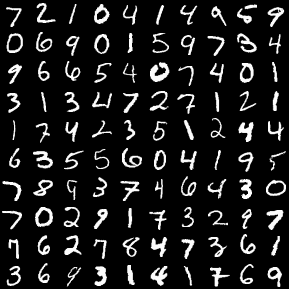

nopretraining


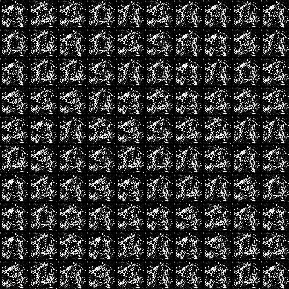

pretrained


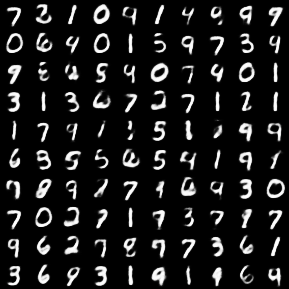

finetuned xtropy 0


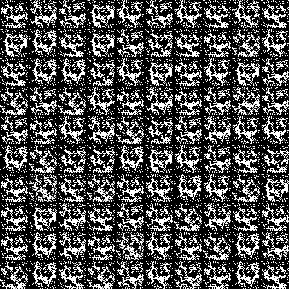

finteuned xtropy 1


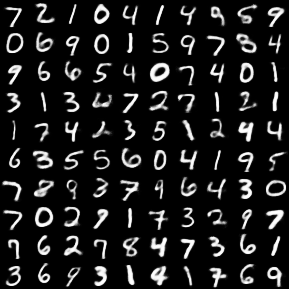

pre-xtropy1 post-xtropy0


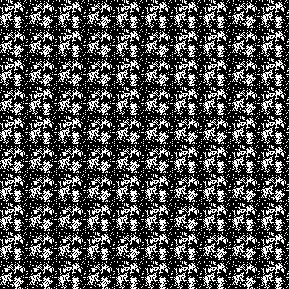

finetuned xtropy 0.5


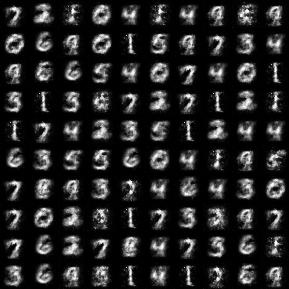

pre-xtropy1 post-xtropy0, slow train


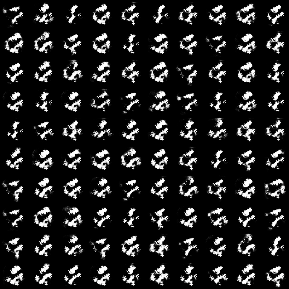

pre-xtropy1 post-xtropy0, slow train, epoch 25


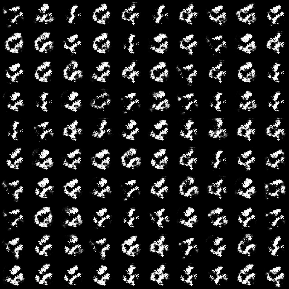

pre-xtropy1 post-xtropy0, slow train, epoch FINAL


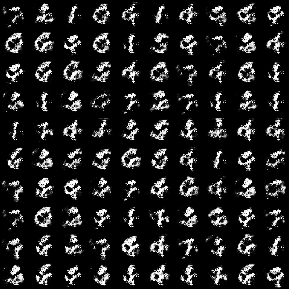

In [13]:
import IPython.display as I

original_img = Image.fromarray(tile_raster_images(X=testx.get_value(),
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('temp.png')
print 'original'
I.display(I.Image('temp.png'))


for (lbl, ssda) in ssdas.items():
    ssda_img = ssda.out_sigmoid_layers[-1].output.eval({ssda.x:testx.get_value()})
    img = Image.fromarray(tile_raster_images(X=ssda_img,
                                             img_shape=(28,28),
                                             tile_shape=(10,10),
                                             tile_spacing=(1,1)))
    
    img.save('temp.png')
    print lbl
    I.display(I.Image('temp.png')) 